# Evaluation of multi-omics GRN inference methods
## Preprocessing multi-omics data
### by Jalil Nourisa

# Imports 

In [2]:
import os
import gzip
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix


import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import seaborn as sns
import json
import anndata as ad
import warnings
# import decoupler as dc

# from venn import venn 

import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})

work_dir = '../../output'
kaggle_data_dir = '/beegfs/desy/user/nourisaj/openproblems_sc_perturbation/input/'
# kaggle_data_dir = '../../input/kaggle/input'
T_cells = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']


In [3]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

# scRNA-seq
We use provided normalized values as X and store the counts in the layers.

## Formatize the data

In [4]:

genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
# get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
# df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
# df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
# mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [7]:
adata_rna = ad.AnnData(X=mrna_sparse_raw, 
                obs=multiome_obs_meta.set_index('obs_id'),
                var=pd.DataFrame(index=df_mrna_pivot_raw.columns)
                )
adata_rna.shape

(25551, 22787)

## Merge cell types

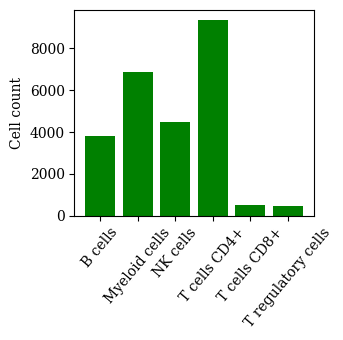

In [8]:
celltype_cellcounts = adata_rna.obs.groupby('cell_type').size()
fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5))
ax.bar(celltype_cellcounts.index, celltype_cellcounts.values, color='green')
ax.tick_params(axis='x', rotation=50)
ax.set_ylabel('Cell count')
# ax.set_title('Distribution of cell count')
plt.tight_layout()
# fig.savefig(f'{work_dir}/preprocess/figs/cellcount_distribution.png', dpi=300)

In [9]:
# make it categorical
adata_rna.obs['cell_type'] = adata_rna.obs['cell_type'].astype('category')
# back up obs
adata_rna.obs['cell_type_original'] = adata_rna.obs['cell_type']
# agg cell type
adata_rna.obs.cell_type = adata_rna.obs.cell_type.apply(lambda name: 'T cells' if (name in T_cells) else name)

In [14]:
adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

## QS

In [3]:
adata_rna = ad.read(f'{work_dir}/scRNA/adata_rna.h5ad')

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [16]:
adata_rna.var['mt'] = adata_rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [17]:
sc.pp.calculate_qc_metrics(
    adata_rna, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
adata_rna

AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type', 'donor_id', 'cell_type_original', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

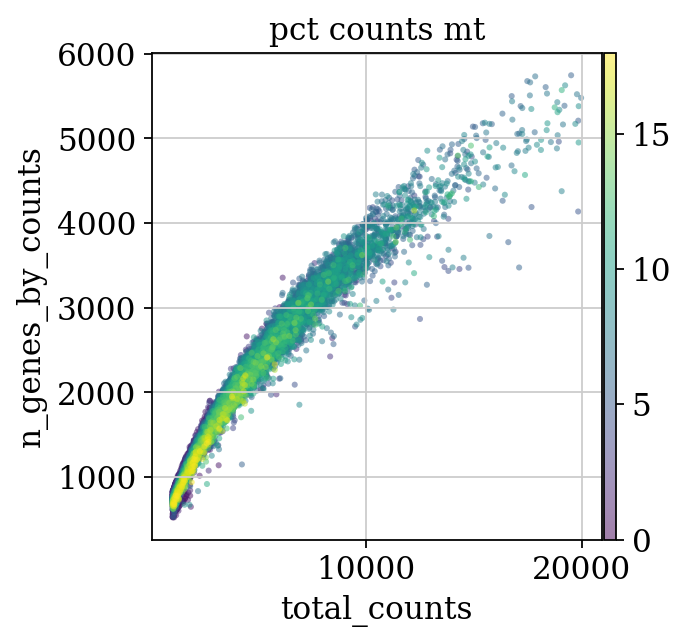

In [18]:
sc.set_figure_params(figsize=(4,4))
p3 = sc.pl.scatter(adata_rna, "total_counts", "n_genes_by_counts", color="pct_counts_mt", size=30, alpha=.5)

In [21]:
adata_rna.var

,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
location,,,,,,,
A1BG,False,1500,0.065125,0.063092,94.129388,1664.0,7.417580
A1BG-AS1,False,1268,0.054479,0.053047,95.037376,1392.0,7.239215
A2M,False,4264,0.275058,0.242991,83.311808,7028.0,8.857800
A2M-AS1,False,1682,0.076983,0.074164,93.417087,1967.0,7.584773
A2ML1,False,97,0.004109,0.004101,99.620367,105.0,4.663439
...,...,...,...,...,...,...,...
ZXDC,False,6808,0.360103,0.307561,73.355250,9201.0,9.127176
ZYG11A,False,78,0.003327,0.003321,99.694728,85.0,4.454347
ZYG11B,False,3910,0.205550,0.186936,84.697272,5252.0,8.566555


In [22]:
total_counts_filter_mask = adata_rna.obs['total_counts']<1000
min_genes_filter_mask = adata_rna.obs['n_genes_by_counts']<500
min_cells_filter_mask = adata_rna.var['n_cells_by_counts']<10
min_cells_filter_mask.sum()

9

In [23]:
# apply filtering
adata_rna = adata_rna[(~min_genes_filter_mask) & (~total_counts_filter_mask), ~min_cells_filter_mask]
adata_rna

View of AnnData object with n_obs × n_vars = 25547 × 22778
    obs: 'cell_type', 'donor_id', 'cell_type_original', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization and clustering

In [24]:
adata_rna.layers['counts'] = adata_rna.X
adata_rna.X.data

/tmp/ipykernel_28893/4280291496.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_rna.layers['counts'] = adata_rna.X


array([1., 1., 1., ..., 2., 1., 1.])

In [25]:
adata_rna.X.data.max()

5810.0

In [26]:
# import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    sc.pp.normalize_total(adata_rna)
    sc.pp.log1p(adata_rna)
    sc.pp.highly_variable_genes(adata_rna, n_top_genes=3000)
    sc.tl.pca(adata_rna, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata_rna, n_neighbors=10, n_pcs=50)
    sc.tl.umap(adata_rna)
adata_rna

AnnData object with n_obs × n_vars = 25547 × 22778
    obs: 'cell_type', 'donor_id', 'cell_type_original', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [27]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata_rna.obs['Donor'] = adata_rna.obs.donor_id.map(map_names)
adata_rna.obs['Cell type'] = adata_rna.obs.cell_type

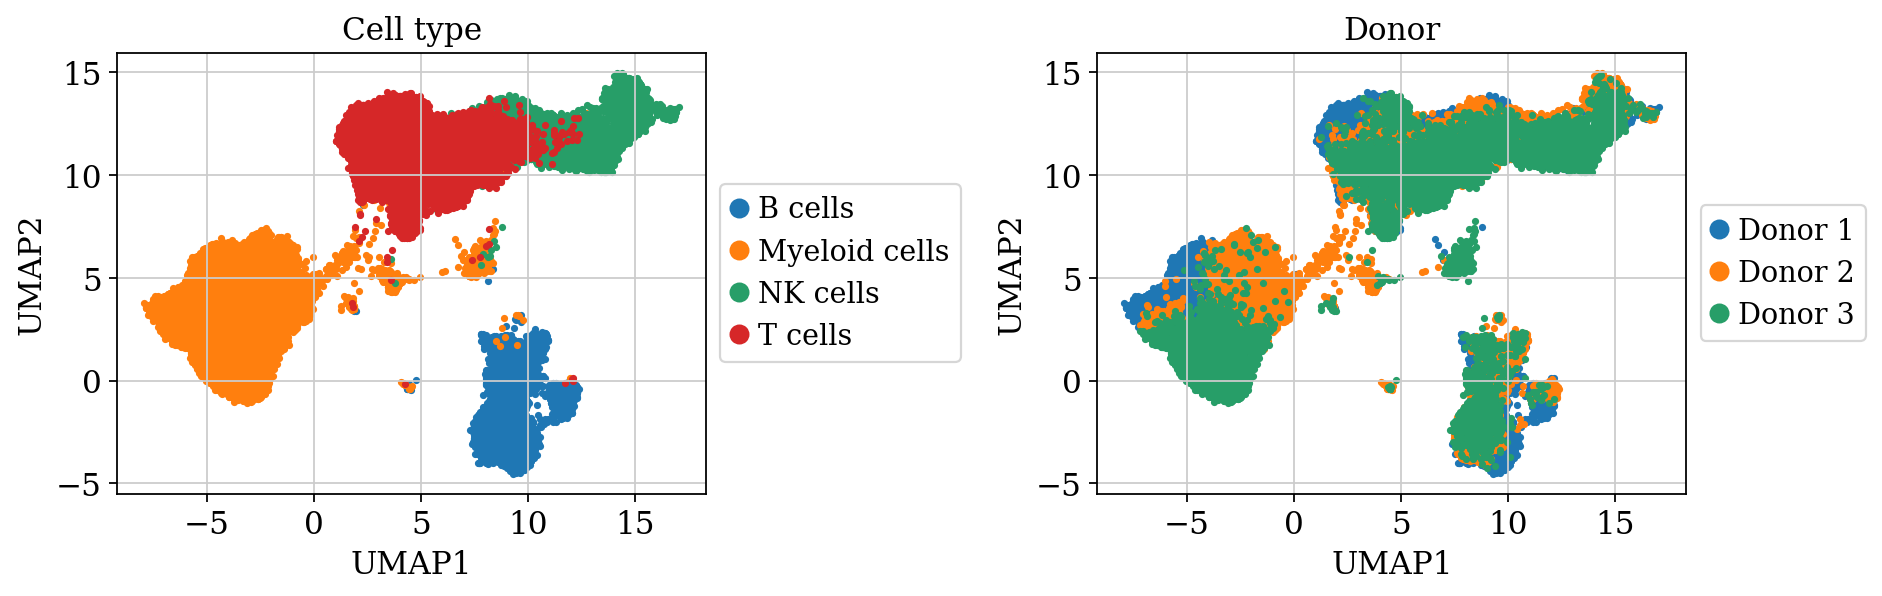

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def cluster_plot(adata, var, ax):
    dim_data = adata.obsm['X_umap']
    legend_handles = []  
    var_unique = sorted(adata.obs[var].unique())  
    var_unique_sorted = sorted(var_unique)  
    for sub_var in var_unique_sorted:
        mask = adata.obs[var] == sub_var
        sub_data = dim_data[mask]
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=5)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

    ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(var)

for i_ax, var in enumerate(['Cell type', 'Donor']): 
    cluster_plot(adata_rna, var, axes[i_ax])

plt.tight_layout()

# fig.savefig(f'{work_dir}/preprocess/figs/rna_cluster.png', dpi=300)
plt.show()


As can be seen, the cell types of B cells and Myeloid cells are clearly seperated while there is more overlap between other cell types. We can also see the under represenation of T cells CD8+ and T regulatory cells. These two cell types are somewhat blended with T cells CD4+. We dont see any clear seggregation for donor_id.

In [31]:
adata_rna.layers['x_norm'] = adata_rna.X
adata_rna.X = adata_rna.layers['counts']

In [33]:
adata_rna.X.data

array([1., 1., 1., ..., 2., 1., 1.])

In [34]:
adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

In [ ]:
aa

# scATAC-seq

## Formatize the data

In [35]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
# del multiome_train

# make adata for each donor and save
def extract_count(count='count'):
    df_peaks_table = df_peaks.pivot_table(index='obs_id', columns='location', values=count)
    df_peaks_table.fillna(0, inplace=True)
    print('df_peaks table created')
    return df_peaks_table
df_peaks_table = extract_count(count='count')
# create adata
X = csr_matrix(df_peaks_table.values)
locations = df_peaks_table.columns
obs_ids = df_peaks_table.index
cell_types = []
for cell in obs_ids:
    cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])




df_peaks table created


NameError: name 'anndata' is not defined

In [36]:
obs = pd.DataFrame(index=obs_ids)
obs['cell_type'] = cell_types
var = pd.DataFrame(index=locations)
adata_atac = ad.AnnData(X=X, obs=obs, var=var)
print('adata is created')

adata is created


In [37]:
split = adata_atac.var_names.str.split(r"[:-]")
adata_atac.var["chrom"] = split.map(lambda x: x[0]).astype(str)
adata_atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
adata_atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
adata_atac.var.head()

,chrom,chromStart,chromEnd
location,,,
GL000194.1:100992-101876,GL000194.1,100992,101876
GL000194.1:104344-105163,GL000194.1,104344,105163
GL000194.1:110741-111545,GL000194.1,110741,111545
GL000194.1:114513-115368,GL000194.1,114513,115368
GL000194.1:27939-28826,GL000194.1,27939,28826


In [38]:
mask_standard_dna = adata_atac.var['chrom'].str.match(r'^chr(?:\d+|X|Y)$')
adata_atac = adata_atac[:,mask_standard_dna]

In [39]:
# add donor info
adata_atac.obs = pd.merge(adata_atac.obs, multiome_obs_meta[['obs_id', 'donor_id']], on='obs_id', how='left')


In [43]:
# save
adata_atac.write(f'{work_dir}/scATAC/adata_atac.h5ad')

## Merge cell type

In [2]:
adata_atac = ad.read(f'{work_dir}/scATAC/adata_atac.h5ad')

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [58]:
# adata_atac.obs.set_index('obs_id',inplace=True)

In [40]:
# make it categorical
adata_atac.obs['cell_type'] = adata_atac.obs['cell_type'].astype('category')
# back up obs
adata_atac.obs['cell_type_original'] = adata_atac.obs['cell_type']
# T cells
adata_atac.obs.cell_type = adata_atac.obs.cell_type.apply(lambda name: 'T cells' if (name in T_cells) else name)

In [41]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata_atac.obs['Donor'] = adata_atac.obs.donor_id.map(map_names)
adata_atac.obs['Cell type'] = adata_atac.obs.cell_type

In [42]:
adata_atac.X.data

array([2., 2., 4., ..., 3., 2., 2.])

## UMAP plot using scATAC-seq


In [66]:
adata_atac.layers['counts'] = adata_atac.X.copy()

In [70]:
adata_atac.layers['counts'].data

array([2., 2., 4., ..., 3., 2., 2.])

In [71]:
# import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    sc.pp.normalize_total(adata_atac)
    sc.pp.log1p(adata_atac)
    sc.pp.highly_variable_genes(adata_atac, n_top_genes=3000)
    sc.tl.pca(adata_atac, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata_atac, n_neighbors=10, n_pcs=50)
    sc.tl.umap(adata_atac)
adata_atac

AnnData object with n_obs × n_vars = 25551 × 135418
    obs: 'cell_type', 'donor_id', 'cell_type_original', 'Donor', 'Cell type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

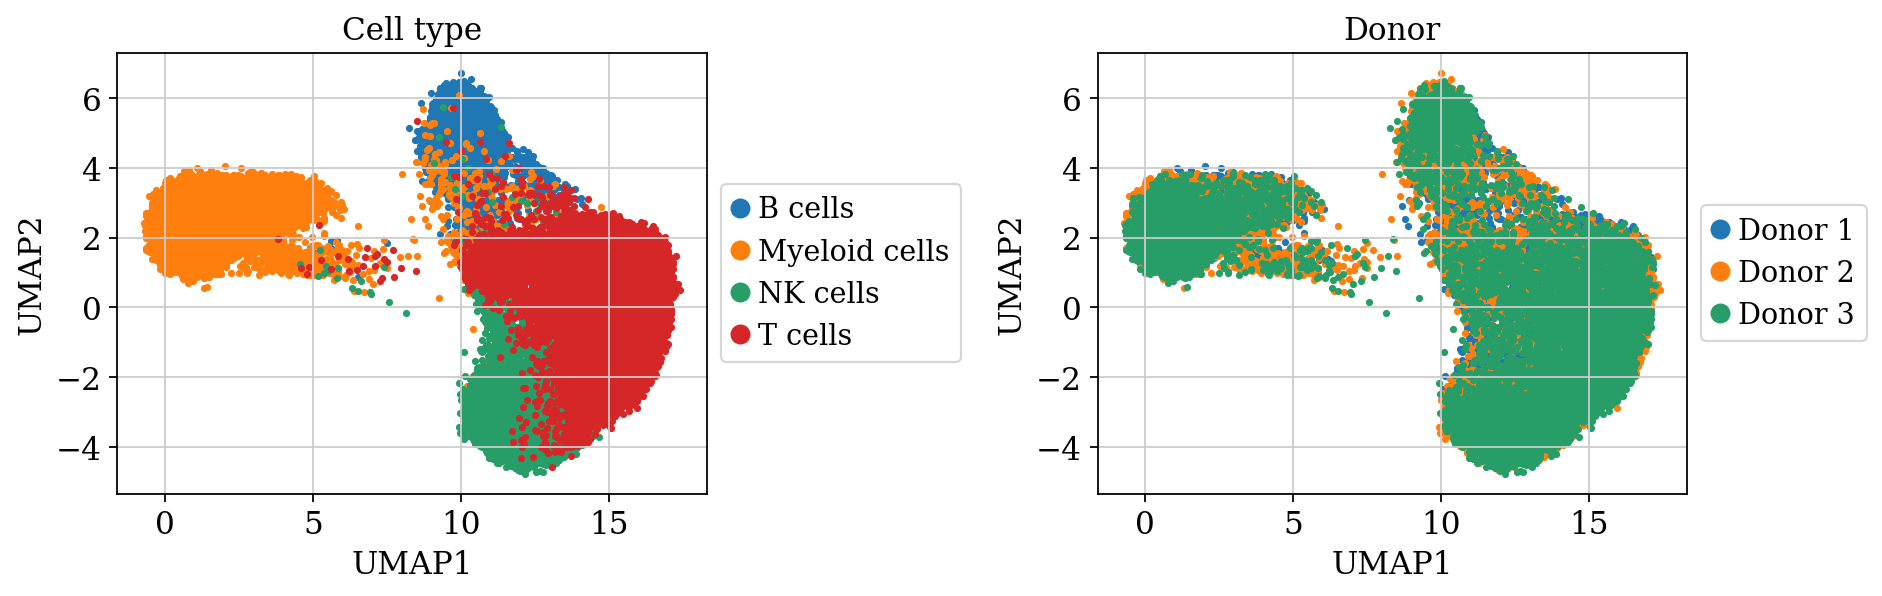

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def cluster_plot(adata, var, ax):
    dim_data = adata.obsm['X_umap']
    legend_handles = []  
    var_unique = sorted(adata.obs[var].unique())  
    var_unique_sorted = sorted(var_unique)  
    for sub_var in var_unique_sorted:
        mask = adata.obs[var] == sub_var
        sub_data = dim_data[mask]
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=5)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

    ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(var)

for i_ax, var in enumerate(['Cell type', 'Donor']): 
    cluster_plot(adata_atac, var, axes[i_ax])

plt.tight_layout()

# fig.savefig(f'{work_dir}/preprocess/figs/atac_cluster.png', dpi=300)
plt.show()


In [73]:
# adata_atac.layers['x_norm'] = adata_atac.X
adata_atac.X = adata_atac.layers['counts']
adata_atac.layers['counts'].data


array([2., 2., 4., ..., 3., 2., 2.])

In [11]:
# save
adata_atac.write(f'{work_dir}/scATAC/adata_atac.h5ad')